In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import pickle
from tqdm import tqdm
from sklearn.metrics import average_precision_score

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline
plt.style.use("bmh")
plt.rc('font', size=14)

In [2]:
def load_image_into_numpy_array(path):
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(
    image_np,
    boxes,
    classes,
    scores,
    category_index,
    figsize=(12, 16),
    image_name=None
):

    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

In [3]:
base_path = "D:\\jupiter\\DB2021F\\"

In [4]:
with open(base_path + 'test', 'rb') as f:
    gt_boxes = pickle.load(f)
len(gt_boxes)

1801

In [5]:
train_idx = list(range(250, 300))
new_boxes = []
for i in train_idx:
    new_boxes.append(gt_boxes[i])
len(new_boxes)

50

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it]


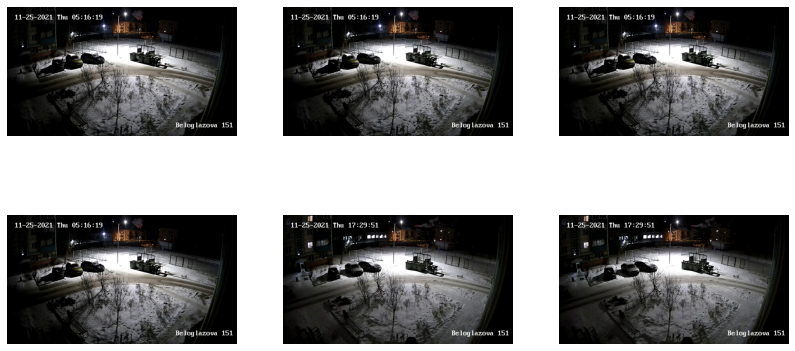

In [6]:
# Load images and visualize
train_image_dir = base_path + "images/"
train_images_np = []
for i in tqdm(train_idx):
    image_path = os.path.join(train_image_dir, 'img_' + str(i) + '.jpg')
    train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np[:6]):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
    plt.axis("off")
plt.show()

In [7]:
tf.keras.backend.clear_session()
trashcan_class_id = 1
num_classes = 1

category_index = {trashcan_class_id: {'id': trashcan_class_id, 'name': 'trash_can'}}

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in tqdm(zip(train_images_np, new_boxes)):
    try:
        train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
        gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
        zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
        gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
    except tf.errors.InternalError:
        continue
        
print(f'Done prepping data [{len(train_image_tensors)}]')

50it [00:02, 22.95it/s]

Done prepping data [50]


In [8]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'object_detection/test_data/checkpoint/ckpt-0'
checkpoint_dir = "D:\\jupiter\\DB2021F\\checks\\"
checkpoint_prefix = os.path.join(checkpoint_dir, "our_detector_ckpt-28-30-31-32-33-34-35")
checkpoint_path = checkpoint_prefix

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor
)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [9]:
@tf.function
def detect(input_tensor):

    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

In [10]:
tf.keras.backend.set_learning_phase(True)

batch_size = 4
learning_rate = 0.01
num_batches = 200

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'
]
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)
        
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    @tf.function
    def train_step_fn(
        image_tensors,
        groundtruth_boxes_list,
        groundtruth_classes_list
    ):
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list
        )
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors], axis=0
            )
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss
    return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\keras\backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [11]:
print('Start fine-tuning!', flush=True)
history_loss = []
for idx in tqdm(range(num_batches)):
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
    history_loss.append(total_loss.numpy())
#ckpt.save(file_prefix=checkpoint_prefix)
print('Done fine-tuning!')

Start fine-tuning!


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:14<00:00,  2.67it/s]

Done fine-tuning!


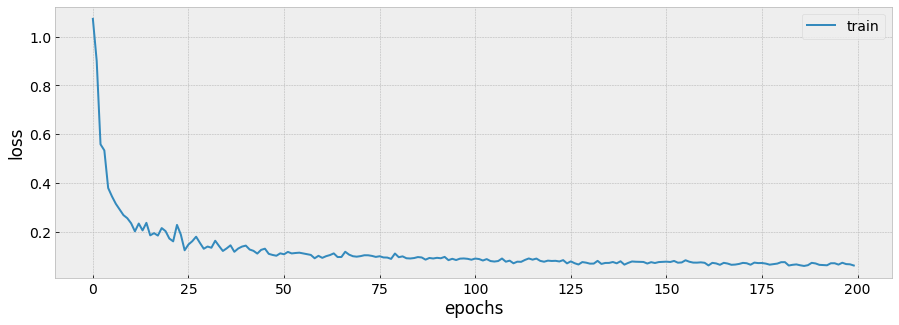

In [12]:
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(history_loss, label="train")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend(loc="best")
plt.show()

In [13]:
del train_images_np

In [80]:
test_idx = list(range(600, 650))

In [81]:
train_image_dir = base_path + "images/"
trashcan_class_id = 1
num_classes = 1
category_index = {trashcan_class_id: {'id': trashcan_class_id, 'name': 'trash_can'}}

gif_path = "D:/jupiter/DB2021F/output/"
test_images_np = []
for i in tqdm(test_idx):
    image_path = os.path.join(train_image_dir, 'img_' + str(i) + '.jpg')
    test_images_np.append(np.expand_dims(load_image_into_numpy_array(image_path), axis=0))
    
detections_list = []
detections_scores = []
detection_classes = []
label_id_offset = 1
for i in tqdm(range(len(test_images_np))):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    detections_list.append(detections['detection_boxes'][0].numpy())
    detections_scores.append(detections['detection_scores'][0].numpy())
    detection_classes.append(detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset)
    
    plot_detections(
        test_images_np[i][0],
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index, figsize=(30, 20), image_name=gif_path + "gif_frame_" + ('%03d' % i) + ".jpg"
    )

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.24it/s]


In [96]:
imageio.plugins.freeimage.download()

In [82]:
anim_file = 'D:/jupiter/DB2021F/trash_predictor.gif'

filenames = os.listdir(gif_path)
filenames = sorted(filenames)[1:]
last = -1
images = []
for filename in tqdm(filenames):
    image = imageio.imread(gif_path + filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.05it/s]


# Метрика

In [ ]:
import pip 
pip.main(['install', 'mapcalc'])

In [16]:
from mapcalc import calculate_map, calculate_map_range

In [77]:
def get_bboxes(bboxes, scores, classes) -> list:
    answ = []
    
    for score, class_id, bbox in zip(scores, classes, bboxes):
        answ.append([
            bbox[2], bbox[0], 
            bbox[3], bbox[1], 0, score
        ])
    return answ

In [87]:
predict_bboxes = []
average_map = 0
for i in range(len(detections_list)):
    predict_bboxes = np.asarray((get_bboxes(detections_list[i], detections_scores[i], detection_classes[i])))
    result_dict = {"boxes": predict_bboxes[:, :4], "labels": predict_bboxes[:, 4], "scores": predict_bboxes[:, -1]}
    truth_bboxes = []
    for j in gt_boxes[i + 600]:
        truth_bboxes.append([
            j[2], j[0], j[3], j[1], 0
        ])
    truth_bboxes = np.asarray(truth_bboxes)   
    ground_truth = {"boxes" : truth_bboxes[:, :-1].astype(float), "labels": truth_bboxes[:, -1]}
    average_map += calculate_map(ground_truth, result_dict, 0.8)
print("mAP: {:.2f}".format(average_map / len(detections_list)))

mAP: 0.83
